In [15]:
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

In [16]:
# 1. Load the Forest CoverType dataset
X, y = fetch_covtype(return_X_y=True)

In [17]:
X, y = fetch_covtype(return_X_y=True)
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
df["target"] = y

# Sample 10% from each class
df_sub = (
    df
    .groupby("target", group_keys=False)
    .apply(lambda grp: grp.sample(frac=0.10, random_state=42))
    .reset_index(drop=True)
)

# Split back into X and y if needed
X_filt = df_sub.drop("target", axis=1).values
y_filt = df_sub["target"].values

print("After filtering:", np.bincount(y_filt).astype(int))

After filtering: [    0 21184 28330  3575   275   949  1737  2051]


/tmp/ipython-input-17-1749060449.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: grp.sample(frac=0.10, random_state=42))


In [19]:
# 3. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_filt,
    test_size=0.2,
    stratify=y_filt,
    random_state=42
)

In [20]:
# 3. Build a pipeline: scaling → logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000, multi_class='auto'))
])

In [21]:
# 4. Define hyperparameter grid
param_grid = {
    # Inverse of regularization strength; lower = stronger regularization
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    # You can also experiment with different solvers
    'logistic__solver': ['liblinear', 'lbfgs']
}

In [22]:
# 5. Set up 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# 6. Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Mean CV accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'logistic__C': 100, 'logistic__solver': 'lbfgs'}
Mean CV accuracy: 0.7244


In [24]:
# 7. Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

acc    = accuracy_score(y_test, y_pred)
prec   = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec    = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1     = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\nTest set performance:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}")

# (Optional) Detailed per-class report
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, zero_division=0))


Test set performance:
  Accuracy : 0.7268
  Precision: 0.7131
  Recall   : 0.7268
  F1-score : 0.7168

Classification report:

              precision    recall  f1-score   support

           1       0.72      0.70      0.71      4237
           2       0.75      0.81      0.78      5666
           3       0.68      0.80      0.74       715
           4       0.64      0.42      0.51        55
           5       0.14      0.01      0.01       190
           6       0.46      0.24      0.32       348
           7       0.70      0.60      0.65       410

    accuracy                           0.73     11621
   macro avg       0.58      0.51      0.53     11621
weighted avg       0.71      0.73      0.72     11621



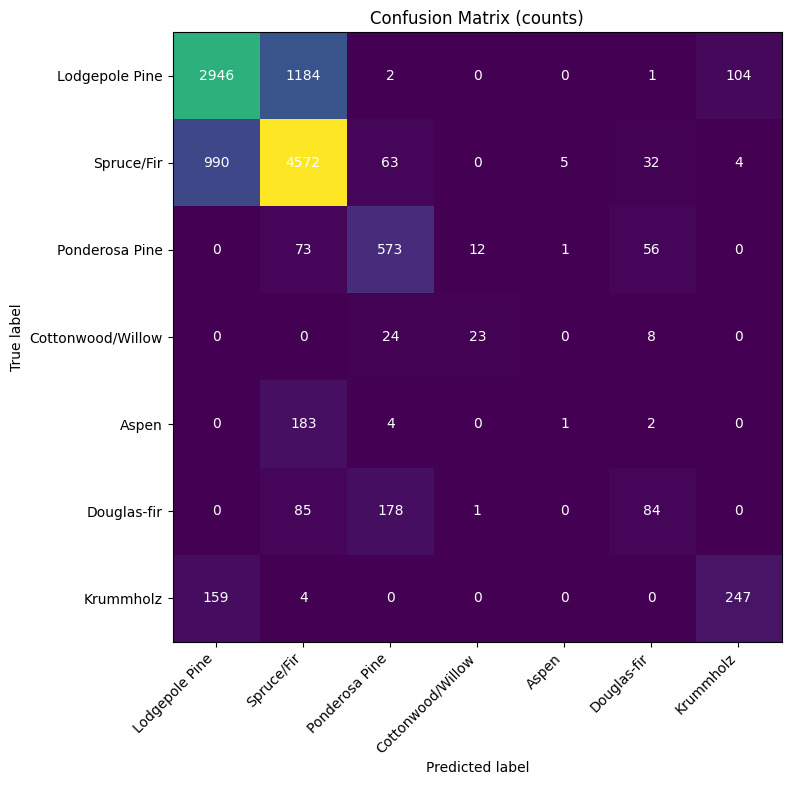

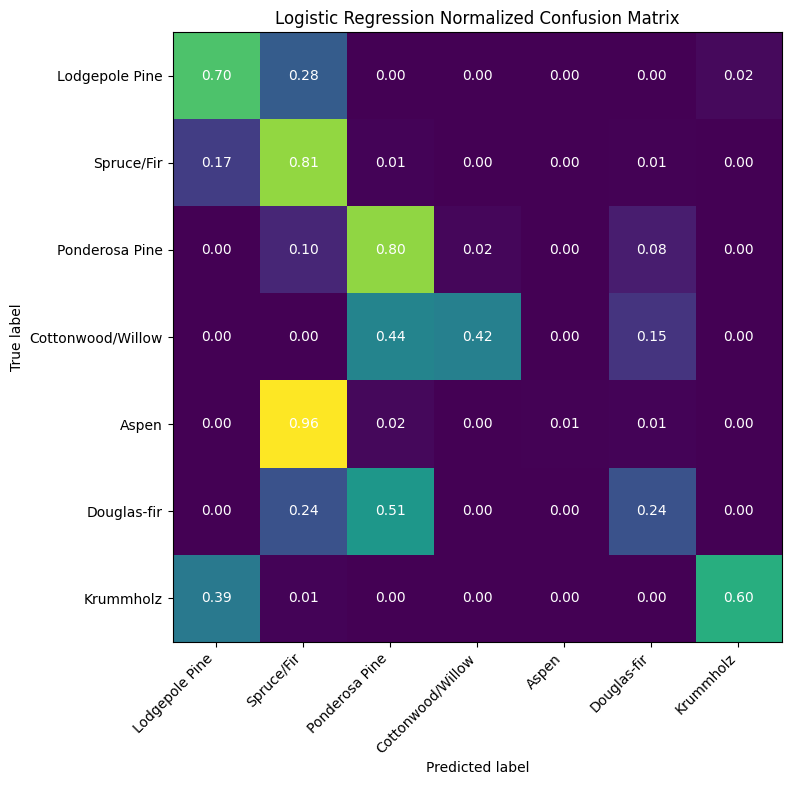

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Your fitted model and test data
# best_model, X_test, y_test, y_pred = ...

# 1. Define the mapping
class_names = {
    1: "Lodgepole Pine",
    2: "Spruce/Fir",
    3: "Ponderosa Pine",
    4: "Cottonwood/Willow",
    5: "Aspen",
    6: "Douglas-fir",
    7: "Krummholz"
}

# 2. Ensure consistent ordering
classes = sorted(class_names.keys())                   # [1,2,3,4,5,6,7]
labels = [class_names[c] for c in classes]             # the human-readable names

# 3. Compute confusion matrices
cm      = confusion_matrix(y_test, y_pred, labels=classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# 4. Plot function
def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    plt.colorbar()
    fmt   = '.2f' if cm.dtype == float else 'd'
    thresh = cm.max() / 2.0

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center",
                    color="white")

    fig.tight_layout()
    return fig

# 5. Generate and save
fig1 = plot_cm(cm,      'Confusion Matrix (counts)')
fig2 = plot_cm(cm_norm, 'Logistic Regression Normalized Confusion Matrix')

#fig1.savefig('cm_counts_named.png', dpi=300, bbox_inches='tight')
fig2.savefig('cm_norm_named.png', dpi=300, bbox_inches='tight')

plt.show()

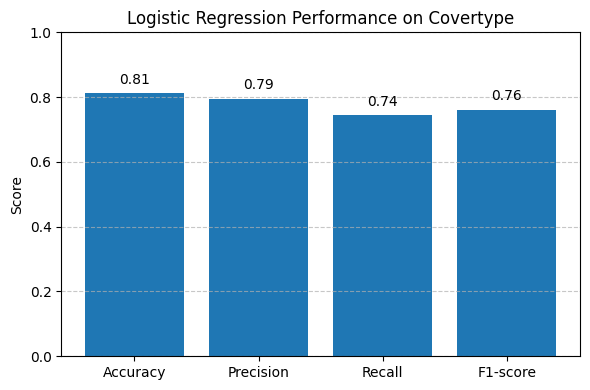

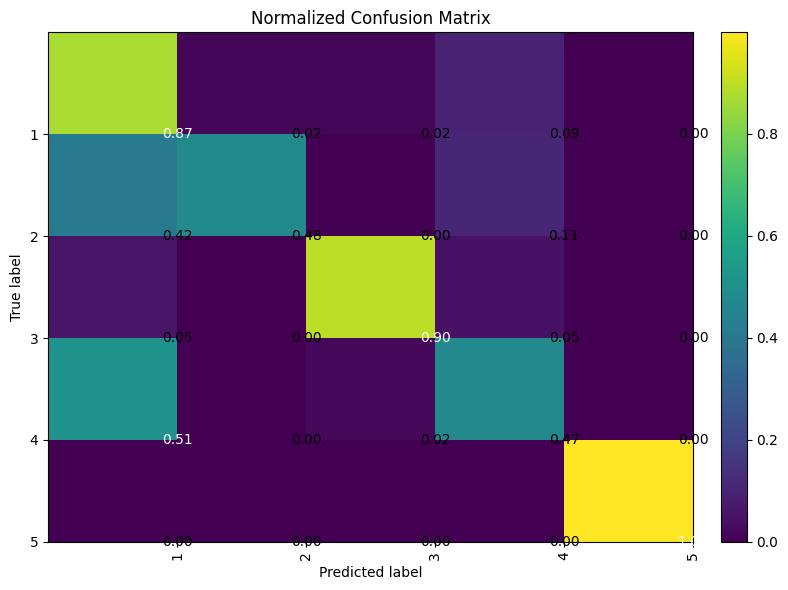

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# — after you’ve computed acc, prec, rec, f1 and y_test, y_pred —

# 1) Bar chart of overall metrics
metrics = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall':    rec,
    'F1-score':  f1
}

plt.figure(figsize=(6,4))
keys = list(metrics.keys())
values = [metrics[k] for k in keys]
bars = plt.bar(keys, values)
plt.ylim(0,1)
plt.ylabel('Score')
plt.title('Logistic Regression Performance on Covertype')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# annotate bars
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.02, f'{h:.2f}',
             ha='center', va='bottom')
plt.tight_layout()
plt.show()


# 2) Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalized by true class

plt.figure(figsize=(8,6))
im = plt.imshow(cm_norm, interpolation='nearest', aspect='auto')
plt.title('Normalized Confusion Matrix')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(cm.shape[0])
plt.xticks(tick_marks + 0.5, tick_marks + 1, rotation=90)  # classes are 1…7
plt.yticks(tick_marks + 0.5, tick_marks + 1)

# annotate each cell
thresh = cm_norm.max() / 2.
for i, j in np.ndindex(cm_norm.shape):
    plt.text(j + 0.5, i + 0.5, f"{cm_norm[i, j]:.2f}",
             ha="center", va="center",
             color="white" if cm_norm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()